### Данные - Ирисы Фишера

В задаче рассматривается подвыборка ирисов фишера, а именно только 2 класса: Versicolor и Virginica. Признаковые описания объектов состоят из 2 величин: petalLength и petalWidth.

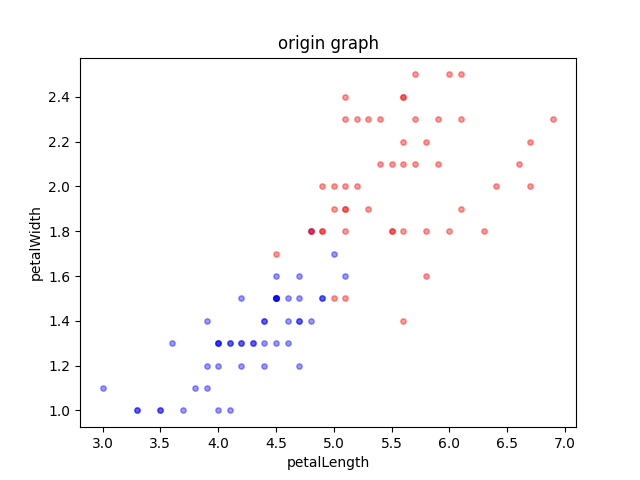

### Описание алгоритма

Пусть есть задача классификации с двумя классами $Y = $ { $-1, +1 $ }. Тогда представим классификатор виде: $a(x, w) = sign f(x,w)$, где $w$ - вектор параметров. Функция под $sign$ называется дискриминантной функцией. Уравнение $f(x, w) = 0$ описывает разделяющую поверхность. 

Отступом назовем величину $M_i(w) = y_i * f(x_i, w)$, если $M < 0$, то значит классификация и изначальный класс имеет разные знаки. Чем больше отступ, тем надежнее классификация.

Если просуммировать оступы на каждом объекте, то получим фунцию потерь от параметров. Минимизация функции по параметрам и есть обучение.

Зададим такую функцию, которая будет мажорировать пороговую функцию, то есть индикатор $[M < 0]$. $ ℒ(M) :  [M < 0] \leq ℒ(M), \forall M$. Тогда минимизацию функцию потерь можно приближенно рассчитать, аппроксимировать через минимизацию мажорирующей функции: 


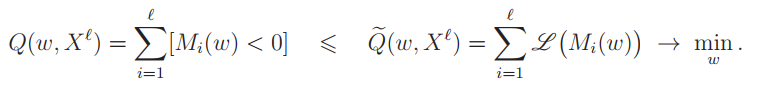

В дальнейшем будут рассмотрены такие аппроксимирующие функции потерь:


*   $E(M) = e^{-M}$ - выбрана произвольно
*   $Q(M) = (1 - M)^2$ - квадратичная в случае ADALINE
*   $V(M) = (1 - M)_+$ - кусочно-линейная в случае перцептрона Розенблатта
*   $L(M) = log_2(1 + e^{-M})$ - логистическая в случае логистической регрессии



Если дискриминантная функция определяется как скалярное произведение вектора $x $ на вектор параметров $w$, то получим линейный классификатор:

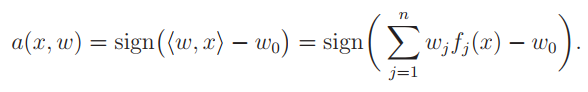

Идея же метода стохастического градиента основана на том, что если положить аппроксимирующую функцию потерь диффиренцируемой, то можно рассчитать ее производную и делать поступательные движения в сторону наибольшего убывания функции. Таким образом можно описать итерационный процесс вычисления весов:

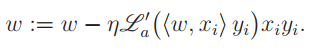

Таким образом, получаем алгоритм, который позволяет подменяя функции потерь, подстраивать его под нужды текущей задачи. 

Для рассчетных алгоритмов используется эвристика (для логистической это необходимость), когда один из признаков принимается за константу, 1 в случае этой реализации. 

### Абстрактный класс

Все методы, являющиеся стохастичискими градиентами наследуются от одного абстрактного класса, что позволяет подменять такие элементы: дискриминантная функция; итерация по эмпирическому риску; итерация по весам; функция потерь; производная функции потерь в явном виде.

In [ ]:
from abc import ABC, abstractmethod
import pandas as pd
import numpy as np


class AbstractSGMethod(ABC):
    _object: list
    range_rows_len: range
    _answer: list
    empirical_risc: float
    weights: np.array
    range_weights_len: range

    def __init__(self, objects: pd.DataFrame, answers: pd.DataFrame, weights, is_column_name=True):
        temp_objects = objects.copy()
        temp_answers = answers.copy()
        if is_column_name:
            temp_objects.columns = objects.iloc[0]
            temp_answers.columns = answers.iloc[0]
        self.objects = temp_objects
        self.answers = temp_answers
        self.weights = weights
        self.range_rows_len = range(len(self.objects))
        self.range_weights_len = range(len(self.weights))
        self.empirical_risc = self.empirical_risc_init()
        print(weights)

    @property
    def objects(self):
        return self._object

    @objects.setter
    def objects(self, val: pd.DataFrame):
        self._object = []
        for index, obj in val.iterrows():
            self._object.append((index, tuple(obj.tolist())))

    @property
    def answers(self):
        return self._answer

    @answers.setter
    def answers(self, val: pd.DataFrame):
        self._answer = []
        for _, answer in val.iterrows():
            self._answer.append(answer.tolist()[0])

    def empirical_risc_init(self):
        res = 0
        for i in self.range_rows_len:
            res += self.lmajor(i)
        return res

    def margin(self, i: int):
        return self.answers[i] * self.disc_func(i)

    def classify(self, i: int):
        if self.disc_func(i) > 0:
            return 1
        return 0

    @abstractmethod
    def empirical_risc_iter(self):
        pass

    @abstractmethod
    def disc_func(self, i: int):
        pass

    @abstractmethod
    def w_iter(self, i: int):
        pass

    @abstractmethod
    def lmajor(self, i: int):
        pass

    @abstractmethod
    def df_lmajor(self, i: int):
        pass

# ADALINE & Perceptron

### Код программы

Реализация линейного классификатора с экспоненциальной функцией потерь:

In [ ]:
import pandas as pd
import utils
import numpy as np
import random
import math


class StochasticGradientExp(AbstractSGMethod):
    lam: float
    eta: float

    def __init__(self, objects: pd.DataFrame, answers: pd.DataFrame, lam, weights, is_column_name=True):
        self.lam = lam
        self.eta = 1
        super().__init__(objects, answers, weights, is_column_name)

    def find_params(self, w_epsilon, er_epsilon):
        xi = random.choice(range(0, 50))

        a = self.classify(xi)
        epsilon = self.lmajor(xi)

        w_difference = abs(self.w_iter(xi))
        temp_emp_r = self.empirical_risc
        self.empirical_risc = self.empirical_risc_iter(epsilon)
        er_difference = abs(temp_emp_r - self.empirical_risc)

        t = 2
        self.eta = self.eta_iter(t)
        while w_difference > w_epsilon or er_difference > er_epsilon:
            if t % 2 == 0:
                xi = random.choice(range(50, 100))
            else:
                xi = random.choice(range(0, 50))

            a = self.classify(xi)
            epsilon = self.lmajor(xi)

            w_difference = abs(self.w_iter(xi))
            temp_emp_r = self.empirical_risc
            self.empirical_risc = self.empirical_risc_iter(epsilon)
            er_difference = abs(temp_emp_r - self.empirical_risc)

            t += 1
            self.eta = self.eta_iter(t)
        return self.weights, self.empirical_risc, w_difference, er_difference

    def empirical_risc_iter(self, epsilon: float = 0):
        return (1 - self.lam) * self.empirical_risc + epsilon * self.lam

    def disc_func(self, i: int):
        return utils.scalar_product(self.objects[i][1], self.weights)

    def w_iter(self,  i: int):
        offset = self.eta * self.df_lmajor(i)
        self.weights = self.weights - offset
        return math.sqrt(utils.scalar_product(offset, offset))

    def lmajor(self, i: int):
        return math.exp(- self.margin(i))

    def df_lmajor(self, i: int):
        return - np.array(self.objects[i][1]) * self.answers[i] * (math.exp(- self.margin(i)))

    def eta_iter(self, t: int):
        return 1 / t

Реализация ADALINE:

In [ ]:
import pandas as pd
import utils
import numpy as np
import random
import math


class StochasticGradientADALINE(AbstractSGMethod):
    lam: float
    eta: float

    def __init__(self, objects: pd.DataFrame, answers: pd.DataFrame, lam, weights, is_column_name=True):
        self.lam = lam
        self.eta = 1
        super().__init__(objects, answers, weights, is_column_name)

    def find_params(self, w_epsilon, er_epsilon):
        xi = random.choice(range(0, 50))

        a = self.classify(xi)
        epsilon = self.lmajor(xi)

        w_difference = self.w_iter(xi)
        temp_emp_r = self.empirical_risc
        self.empirical_risc = self.empirical_risc_iter(epsilon)
        er_difference = abs(temp_emp_r - self.empirical_risc)

        t = 2
        self.eta = self.eta_iter(t)
        while w_difference > w_epsilon or er_difference > er_epsilon:
            if t % 2 == 0:
                xi = random.choice(range(50, 100))
            else:
                xi = random.choice(range(0, 50))

            a = self.classify(xi)
            epsilon = self.lmajor(xi)

            w_difference = self.w_iter(xi)
            temp_emp_r = self.empirical_risc
            self.empirical_risc = self.empirical_risc_iter(epsilon)
            er_difference = abs(temp_emp_r - self.empirical_risc)

            t += 1
            self.eta = self.eta_iter(t)
        return self.weights, self.empirical_risc, w_difference, er_difference

    def empirical_risc_iter(self, epsilon=0):
        return (1 - self.lam) * self.empirical_risc + epsilon * self.lam

    def disc_func(self, i: int, *args):
        return utils.scalar_product(self.objects[i][1], self.weights)

    def w_iter(self,  i: int, *args):
        offset = self.eta * self.df_lmajor(i)
        self.weights = self.weights - offset
        return math.sqrt(utils.scalar_product(offset, offset))

    def lmajor(self, i: int, *args):
        m = 1 - self.margin(i)
        return m * m

    def df_lmajor(self, i: int, *args):
        return 2 * np.array(self.objects[i][1]) * (utils.scalar_product(self.weights, self.objects[i][1]) - self.answers[i])

    def eta_iter(self, t: int):
        return 1 / t

    def eta_iter_i(self, i: int):
        x_norm = utils.scalar_product(self.objects[i][1], self.objects[i][1])
        return 1 / (x_norm * x_norm)

Реализация перцептрона:

In [ ]:
import pandas as pd
import utils
import numpy as np
import random
import math


class StochasticGradientPR(asg.AbstractSGMethod):
    lam: float
    eta: float

    def __init__(self, objects: pd.DataFrame, answers: pd.DataFrame, lam, weights, is_column_name=True):
        self.lam = lam
        self.eta = 1
        super().__init__(objects, answers, weights, is_column_name)

    def find_params(self, w_epsilon, er_epsilon):
        xi = random.choice(range(0, 50))

        a = self.classify(xi)
        epsilon = self.lmajor(xi)

        w_difference = abs(self.w_iter(xi))
        temp_emp_r = self.empirical_risc
        self.empirical_risc = self.empirical_risc_iter(epsilon)
        er_difference = abs(temp_emp_r - self.empirical_risc)

        t = 2
        self.eta = self.eta_iter(t)
        while w_difference > w_epsilon or er_difference > er_epsilon:
            print(w_difference, er_difference)
            if t % 2 == 0:
                xi = random.choice(range(50, 100))
            else:
                xi = random.choice(range(0, 50))

            a = self.classify(xi)
            epsilon = self.lmajor(xi)

            w_difference = abs(self.w_iter(xi))
            temp_emp_r = self.empirical_risc
            self.empirical_risc = self.empirical_risc_iter(epsilon)
            er_difference = abs(temp_emp_r - self.empirical_risc)

            t += 1
            self.eta = self.eta_iter(t)
        return self.weights, self.empirical_risc, w_difference, er_difference

    def empirical_risc_iter(self, epsilon: float = 0):
        return (1 - self.lam) * self.empirical_risc + epsilon * self.lam

    def disc_func(self, i: int):
        return utils.scalar_product(self.objects[i][1], self.weights)

    def w_iter(self,  i: int):
        if self.margin(i) < 0:
            offset = self.eta * self.df_lmajor(i)
            self.weights = self.weights - offset
            return math.sqrt(utils.scalar_product(offset, offset))
        return 0

    def lmajor(self, i: int):
        return max(1 - self.margin(i), 0)

    def df_lmajor(self, i: int):
        return - np.array(self.objects[i][1]) * self.answers[i]

    def eta_iter(self, t: int):
        return 1 / t


### Результаты

В результате обучения были построены такие разделяющие линии:

Для экспоненциальной функции:

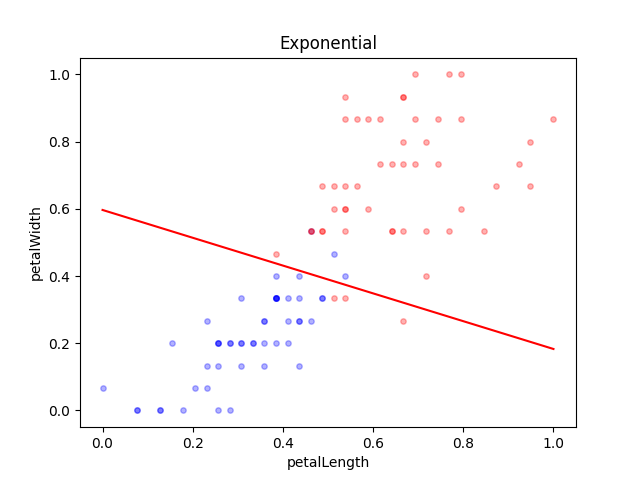

Начальные веса: (0, 0, 0)

Точность алгоритма:

Пока изменения по весам больше 0.1 и изменения по эмпирическому риску больше 0.00001.

Сходимость достигается за 662 шага, риск равен 0.7754. Конечный вектор весов: (0.7656, 1.8506, 1.1039)

Для квадратичной:

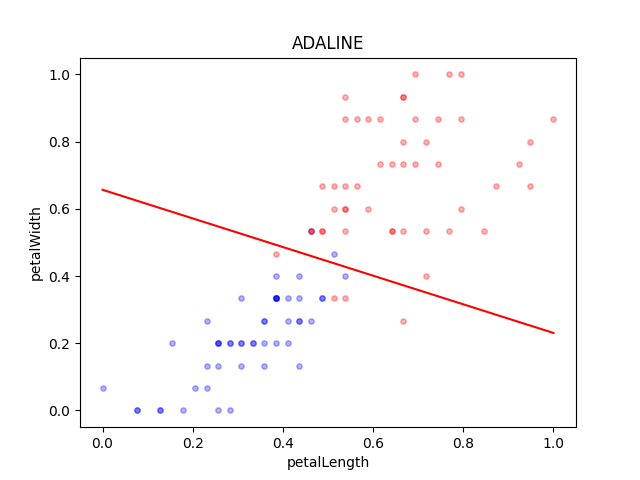

Начальные веса: (0.02716, 0.028, 0.1552)

Точность алгоритма:

Пока изменения по весам больше 0.1 и изменения по эмпирическому риску больше 0.00001.

Сходимость достигается за 665 шагов, риск равен 0.4349. Конечный вектор весов: (0.9108, 2.1377 , 1.4036)

Для правила Хебба:

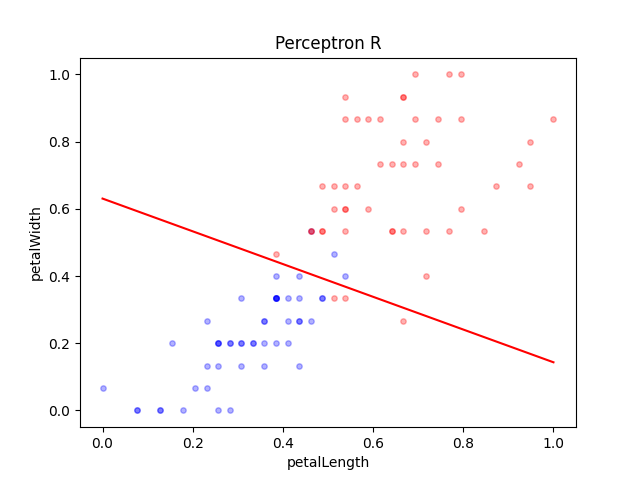

Начальные веса: (0.02716, 0.028, 0.1552)

Точность алгоритма:

Пока изменения по весам больше 0.1 и изменения по эмпирическому риску больше 0.00001.

Сходимость достигается за 843 шага, риск равен 0.9415. Конечный вектор весов: (0.1142, 0.2344, 0.1477)

На одном графике:

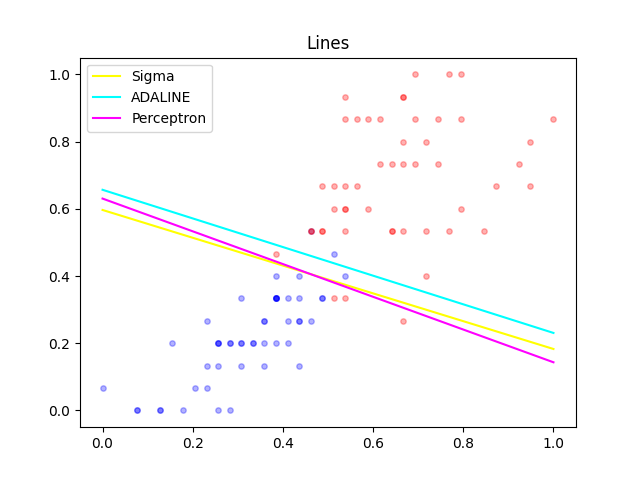

# Logistic regression

### Описание алгоритма

Плотность распределения $p(x)$ называется экспонентной, если $p(x) = exp(c(δ)<θ, x> + b(δ, θ) + d(x, δ))$. Так например многомерное нормально распределение является (может быть сведено к виду) экспонентным распределением:

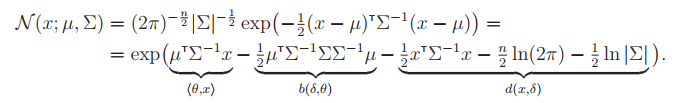

Предположим, что множество прецедентов $X\times Y$ - вероятностное пространство. Выборка $X^l$ получена случайно и независимо согласно вероятностному распределению с плотностью $p(x,y)=P_y*p_y(x)=P(y|x)p(x)$, где $P_y$ - априорные вероятности классов, $p_y(x)$ - функции правдоподобия, $P(y|x)$ - апостериорные вероятности классов $y \in Y$.

Предположим, также, что функции правдоподобия классов принадлежат экспонентному семейству плотностей, имеют равные значения параметров d и δ, но отличаются параметрами сдвига $θ_y$.

Подставим в оптимальный байесовский классификатор: $a(x) = argmax_{y\in Y}λ_yP(y|x)$, где $λ_y$ - штраф за ошибку на объектах соответствующего класса. Тогда в случае 2 классов получим:

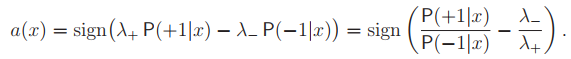

Исходя из всего вышесказанного и того, что среди признаков есть константа можно доказать, что:


Байесовский классификатор является линейным:

$a(x) = sign(<w,x> - w_0), \text{где } w_0 = ln(\frac{λ_-}{λ_+})$ 


Апостериорная вероятность принадлежности объекта x к классу y может быть вычесленна по значению дикриминантной функции:

$P(y|x) = σ(<w,x>y), \text{где } σ(z)=\frac{1}{1 - e^{-z}}$ - сигмоидная функция



Перейдя к задаче настройки весов будем использовать принцип максимума правдоподобия. Тогда максимизируя функционал, аппроксимирующий функцию правдоподобия выборки:

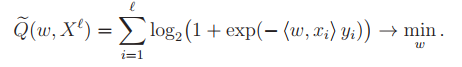

Видно, что $ℒ(M) = log_2(1 + e^{-M})$

Правило итерации для весов имеет вид:

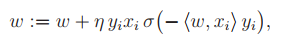

Что является сглаженным правилом Хебба.

### Код программы

Реализация класса логистической регрессии:

In [ ]:
import pandas as pd
import utils
import numpy as np
import random
import math


class StochasticGradientLOG(asg.AbstractSGMethod):
    lam: float
    eta: float

    def __init__(self, objects: pd.DataFrame, answers: pd.DataFrame, lam, weights, is_column_name=True):
        self.lam = lam
        self.eta = 1
        super().__init__(objects, answers, weights, is_column_name)

    def find_params(self, w_epsilon, er_epsilon):
        xi = random.choice(range(0, 50))

        a = self.classify(xi)
        epsilon = self.lmajor(xi)

        w_difference = abs(self.w_iter(xi))
        temp_emp_r = self.empirical_risc
        self.empirical_risc = self.empirical_risc_iter(epsilon)
        er_difference = abs(temp_emp_r - self.empirical_risc)

        t = 2
        self.eta = self.eta_iter(t)
        while w_difference > w_epsilon or er_difference > er_epsilon:
            if t % 2 == 0:
                xi = random.choice(range(50, 100))
            else:
                xi = random.choice(range(0, 50))

            a = self.classify(xi)
            epsilon = self.lmajor(xi)

            w_difference = abs(self.w_iter(xi))
            temp_emp_r = self.empirical_risc
            self.empirical_risc = self.empirical_risc_iter(epsilon)
            er_difference = abs(temp_emp_r - self.empirical_risc)

            t += 1
            self.eta = self.eta_iter(t)

        res = []
        for i in self.range_rows_len:
            res.append((1 + math.exp(- self.margin(i)))/(1 + math.exp(self.margin(i))))

        return self.weights, res, self.empirical_risc, w_difference, er_difference

    def empirical_risc_iter(self, epsilon: float = 0):
        return (1 - self.lam) * self.empirical_risc + epsilon * self.lam

    def disc_func(self, i: int):
        return utils.scalar_product(self.objects[i][1], self.weights)

    def w_iter(self,  i: int):
        if self.margin(i) < 0:
            offset = np.array(self.objects[i][1]) * self.eta * self.answers[i] * self.df_lmajor(i)
            self.weights = self.weights - offset
            return math.sqrt(utils.scalar_product(offset, offset))
        return 0

    def lmajor(self, i: int):
        return math.log2(self.sigma(i))

    def df_lmajor(self, i: int):
        e = math.exp(- self.margin(i))
        return - e / ((e + 1) * math.log(2))

    def eta_iter(self, t: int):
        return 1 / t

    def sigma(self, i):
        return 1 + math.exp(- self.margin(i))

### Результаты

Для логистической регрессии получилась прямая:

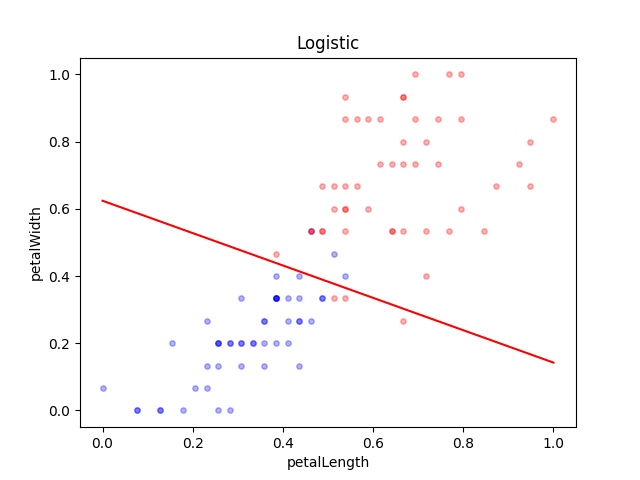

Начальные веса: (0.02716, 0.028, 0.1552)

Точность алгоритма:

Пока изменения по весам больше 0.1 и изменения по эмпирическому риску больше 0.00001.

Сходимость достигается за 700 шагов, риск равен 1.0282.

Карта вероятностей, чем темнее цвет, тем больше вероятность:

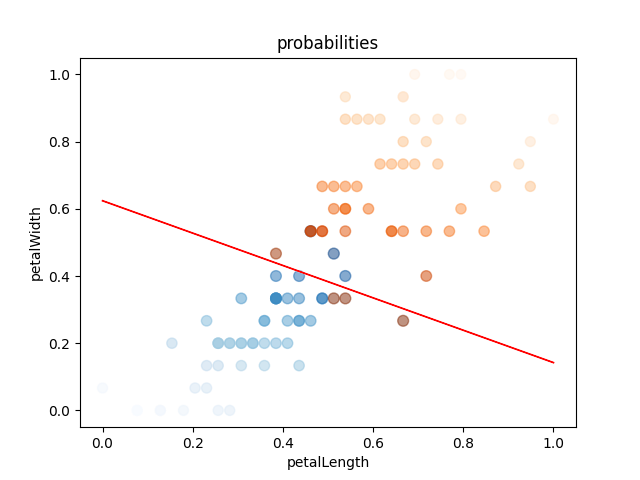

На одном графике с предыдущими линиями:

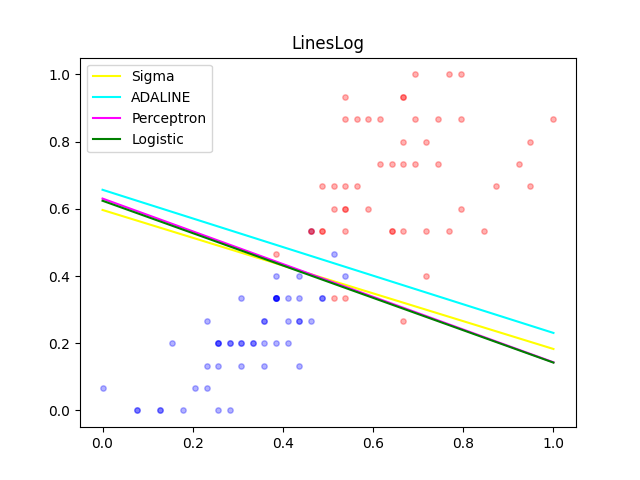